# 04 - Metropolis MC and Simulated Annealing

In this example, we will perform Metropolis MC and simulated annealing runs for Lennard-Jones clusters in a box with infinite walls.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def lj_potential(r, sigma=1.0, epsilon=1.0):
    r"""
    Compute the Lennard-Jones potential.
    
    Parameters
    ----------
    r : float or array-like of float
        Euklidean particle-particle distance(s).
    sigma : float, optional, default=1.0
        Zero crossing distance.
    epsilon : float, optional, default=1.0
        Depth of the potential well.
    
    Returns
    -------
    float or array-like of float
        Lennard-Jones energy value(s).
    
    """
    q = (sigma / r)**6
    return 4.0 * (epsilon * (q * (q - 1.0)))

def interaction_potential(xyz, sigma=1.0, epsilon=1.0):
    r"""
    Compute the interaction potential for a set of particles.
    
    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d))
        d-dimensional coordinates of n particles.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    
    Returns
    -------
    float
        Total interaction potential.
    
    """
    lj_interaction = 0.0
    for i in range(1, xyz.shape[0]):
        lj_interaction_tmp = 0.0
        for j in range(i):
            r = np.linalg.norm(xyz[j, :] - xyz[i, :])
            lj_interaction_tmp += lj_potential(r, sigma=sigma, epsilon=epsilon)
        lj_interaction += lj_interaction_tmp
    return lj_interaction

def external_potential(xyz, box_length=None):
    r"""
    Compute the external potential for a set of particles.
    
    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d))
        d-dimensional coordinates of n particles.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    
    Returns
    -------
    float
        Total external potential.
    
    """
    if box_length is None:
        return 0.0
    if np.all(xyz >= 0.0) and np.all(xyz <= box_length):
        return 0.0
    return np.inf

def phi(xyz, sigma=1.0, epsilon=1.0, box_length=None):
    r"""
    Compute the interaction and external potential for a set of particles.
    
    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d))
        d-dimensional coordinates of n particles.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    
    Returns
    -------
    float
        Total interaction and external potential.
    
    """
    return interaction_potential(xyz, sigma=sigma, epsilon=epsilon) + external_potential(xyz, box_length=box_length)

def metropolis_update(xyz, pot, sigma=1.0, epsilon=1.0, box_length=None, step=0.1, beta=1.0):
    r"""
    Perform a Metropolis update step.
    
    Parameters
    ----------
    xyz : numpy.ndarray(shape=(n, d))
        d-dimensional coordinates of n particles.
    pot : float
        Potential value of xyz.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    step : float, optional, default=0.1
        Maximal size of an update move in each coordinate.
    beta : float, optional, default=1.0
        Inverse temperature factor (1/kT).
    
    Returns
    -------
    float
        Total interaction and external potential.
    
    """
    xyz_trial = xyz + 2.0 * step * (np.random.rand(*xyz.shape) - 0.5)
    pot_trial = phi(xyz_trial, sigma=sigma, epsilon=epsilon, box_length=box_length)
    if pot_trial <= pot or np.random.rand() < np.exp(beta * (pot - pot_trial)):
        return xyz_trial, pot_trial
    return xyz, pot

def metropolis(xyz_init, size, sigma=1.0, epsilon=1.0, box_length=None, step=0.1, beta=1.0):
    r"""
    Perform a Metropolis MC sampling procedure.
    
    Parameters
    ----------
    xyz_init : numpy.ndarray(shape=(n, d)) or similar
        Initial d-dimensional coordinates of n particles.
    size : int
        Number of Metropolis update steps.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    step : float, optional, default=0.1
        Maximal size of an update move in each coordinate.
    beta : float, optional, default=1.0
        Inverse temperature factor (1/kT).
    
    Returns
    -------
    float
        Total interaction and external potential.
    
    """
    xyz_traj = [np.asarray(xyz_init, dtype=np.float64)]
    pot_traj = [phi(xyz_traj[-1], sigma=sigma, epsilon=epsilon, box_length=box_length)]
    for i in range(size):
        xyz, pot = metropolis_update(
            xyz_traj[-1], pot_traj[-1],
            sigma=sigma, epsilon=epsilon, box_length=box_length,
            step=step, beta=beta)
        xyz_traj.append(xyz)
        pot_traj.append(pot)
    return np.asarray(xyz_traj, dtype=np.float64), np.asarray(pot_traj, dtype=np.float64)

def metropolis_sa(xyz_init, size, sigma=1.0, epsilon=1.0, box_length=None, step=0.1, beta=1.0):
    r"""
    Perform a Metropolis-based simulated annealing procedure.
    
    Parameters
    ----------
    xyz_init : numpy.ndarray(shape=(n, d)) or similar
        Initial d-dimensional coordinates of n particles.
    size : int
        Number of Metropolis update steps.
    sigma : float, optional, default=1.0
        Zero crossing distance for the Lennard-Jones contribution.
    epsilon : float, optional, default=1.0
        Depth of the potential well for the Lennard-Jones contribution.
    box_length : float, optional, default=None
        If not None, the area outside [0, box_length]^d
        is forbidden for each particle.
    step : float, optional, default=0.1
        Maximal size of an update move in each coordinate.
    beta : float, optional, default=1.0
        Initial inverse temperature factor (1/kT).
    
    Returns
    -------
    float
        Total interaction and external potential.
    
    """
    beta_values = 1.0 / np.linspace(1.0E-15, 1.0 / beta, size)[::-1]
    xyz_traj = [np.asarray(xyz_init, dtype=np.float64)]
    pot_traj = [phi(xyz_traj[-1], sigma=sigma, epsilon=epsilon, box_length=box_length)]
    for i in range(size):
        xyz, pot = metropolis_update(
            xyz_traj[-1], pot_traj[-1],
            sigma=sigma, epsilon=epsilon, box_length=box_length,
            step=step, beta=beta_values[i])
        xyz_traj.append(xyz)
        pot_traj.append(pot)
    return np.asarray(xyz_traj, dtype=np.float64), np.asarray(pot_traj, dtype=np.float64)

## Exercise

We perform two MCMC runs at $\beta=1$ and $\beta=10$:

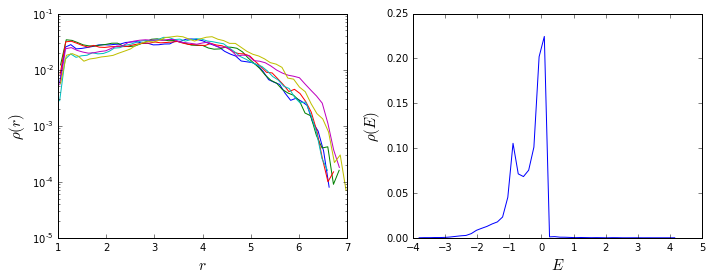

In [3]:
xyz, pot = metropolis(np.random.rand(4, 3) * 5.0, 101000, box_length=5.0, beta=1.0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i in range(1, 4):
    for j in range(i):
        hist, edges = np.histogram(np.linalg.norm(xyz[1000:, j, :] - xyz[1000:, i, :], axis=-1), bins=50)
        rho = hist.astype(np.float64) / np.sum(hist)
        axes[0].plot(edges[1:], rho)
axes[0].set_xlabel(r"$r$", fontsize=15)
axes[0].set_ylabel(r"$\rho(r)$", fontsize=15)
axes[0].semilogy()
hist, edges = np.histogram(pot[1000:], bins=50)
rho = hist.astype(np.float64) / np.sum(hist)
axes[1].plot(edges[1:], rho)
axes[1].set_xlabel(r"$E$", fontsize=15)
axes[1].set_ylabel(r"$\rho(E)$", fontsize=15)
fig.tight_layout()

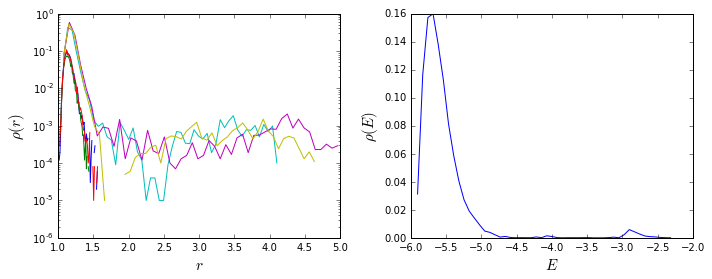

In [4]:
xyz, pot = metropolis(np.random.rand(4, 3) * 5.0, 101000, box_length=5.0, beta=10.0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i in range(1, 4):
    for j in range(i):
        hist, edges = np.histogram(np.linalg.norm(xyz[1000:, j, :] - xyz[1000:, i, :], axis=-1), bins=50)
        rho = hist.astype(np.float64) / np.sum(hist)
        axes[0].plot(edges[1:], rho)
axes[0].set_xlabel(r"$r$", fontsize=15)
axes[0].set_ylabel(r"$\rho(r)$", fontsize=15)
axes[0].semilogy()
hist, edges = np.histogram(pot[1000:], bins=50)
rho = hist.astype(np.float64) / np.sum(hist)
axes[1].plot(edges[1:], rho)
axes[1].set_xlabel(r"$E$", fontsize=15)
axes[1].set_ylabel(r"$\rho(E)$", fontsize=15)
fig.tight_layout()

We observe that, at $\beta=1$ the Markov chain contains many samples over the range $r\in[1, 4]$, while the $\beta=10$ Markov chain primarily samples the range $r\in[1, 1.5]$.

## Simulated Annealing

Here, we introduce a variant of Metropolis MC for structural optimization. As we have seen in the previous exercise, a Metropolis MC procedure at low temperatures samples mostly in the low energy, i.e. stable, regions. Thus, if we perform a Metropolis MC run with constantly decreasing temperature, the resulting Markov chain should converge towards the most (or at least one) stable structure.

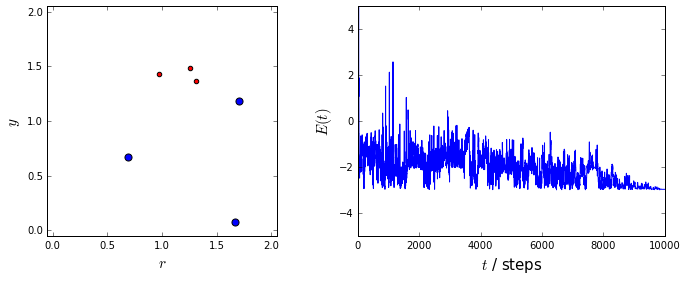

In [5]:
xy, pot = metropolis_sa(np.random.rand(3, 2) + 0.5, 10000, box_length=2.0, beta=1.0)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(xy[0, :, 0], xy[0, :, 1], c="red")
axes[0].scatter(xy[-1, :, 0], xy[-1, :, 1], c="blue", s=50)
axes[0].set_aspect('equal')
axes[0].set_xlim(-0.05, 2.05)
axes[0].set_ylim(-0.05, 2.05)
axes[0].set_xlabel(r"$r$", fontsize=15)
axes[0].set_ylabel(r"$y$", fontsize=15)
axes[1].plot(pot)
axes[1].set_xlabel(r"$t$ / steps", fontsize=15)
axes[1].set_ylabel(r"$E(t)$", fontsize=15)
axes[1].set_ylim(-5, 5)
fig.tight_layout()

The red and blue markers in the left panel denote the randomized initial structure and the last frame of the resulting Markov chain. The curve in the right panel shows how the energy of the system changed over time.

## Further exercises

1. use a cutoff at $r_c$ for the Lennard-Jones interaction;
2. use periodic boundary conditions with minimal image convention instead of infinite walls and assume a cell size $\geq 2 r_c$;
3. use a neighbor list scheme during the interaction potential calculation.